In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install scikit-optimize

In [302]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel
from skopt import BayesSearchCV
from time import time

## 1 . Data Preprocessing and Exploration


### 1.1 Data Preparation
- Load a sample (1%) from the huge HIGGS dataset into a Pandas DataFrame.
- Rename the columns to have a consistent format, with the first column as "label" and the subsequent columns labeled as "feature_1" through "feature_28".
- The target variable (`target`) is extracted from the "label" column, while the features are stored in a separate DataFrame (`data`).

In [303]:
# Load HIGGS_sample
filepath = "/content/HIGGS_sample.csv"
read_data = pd.read_csv(filepath)

columns = ["label"] + [f"feature_{i}" for i in range(1, 29)]
read_data.columns = columns

data = read_data.drop(columns=['label'])
target = read_data['label']

read_data.head() # Display first few rows

,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28
0,1.0,0.532373,-0.563982,-0.707137,0.682998,0.702177,2.064735,-1.227911,0.030652,0.000000,...,-0.234484,-1.359247,0.000000,0.671950,2.374774,0.981455,0.856261,0.995606,1.971345,1.486434
1,0.0,0.341129,0.069098,0.325565,2.925696,0.500175,1.929798,-0.790229,-1.300509,2.173076,...,0.135289,1.291674,3.101961,2.793955,1.845023,0.971333,3.271633,1.187914,1.998760,2.342642
2,1.0,1.768051,-0.226015,-1.334685,1.382299,0.217815,0.470495,-0.552574,0.669846,0.000000,...,1.217127,1.470911,0.000000,0.977827,0.756365,2.134194,1.172502,0.651040,0.825880,0.750081
3,0.0,0.716481,-0.800656,-1.245352,0.648034,0.972671,0.600302,0.714921,1.638340,0.000000,...,-0.047932,0.899351,3.101961,1.488407,0.917862,0.983844,0.791456,0.491298,0.732747,0.750671
4,0.0,0.327586,1.395643,1.130114,1.191988,0.713228,0.883368,0.884250,-1.577697,2.173076,...,-0.337754,-0.480818,3.101961,0.852777,1.272682,0.992933,0.824094,1.227924,0.882994,0.805299


### 1.2 Exploratory Data Analysis (EDA)
Analyze the dataset, and visualize feature distributions.

In [304]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 28 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   feature_1   110000 non-null  float64
 1   feature_2   110000 non-null  float64
 2   feature_3   110000 non-null  float64
 3   feature_4   110000 non-null  float64
 4   feature_5   110000 non-null  float64
 5   feature_6   110000 non-null  float64
 6   feature_7   110000 non-null  float64
 7   feature_8   110000 non-null  float64
 8   feature_9   110000 non-null  float64
 9   feature_10  110000 non-null  float64
 10  feature_11  110000 non-null  float64
 11  feature_12  110000 non-null  float64
 12  feature_13  110000 non-null  float64
 13  feature_14  110000 non-null  float64
 14  feature_15  110000 non-null  float64
 15  feature_16  110000 non-null  float64
 16  feature_17  110000 non-null  float64
 17  feature_18  110000 non-null  float64
 18  feature_19  110000 non-null  float64
 19  fe

In [305]:
data.describe()  # summary statistics

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28
count,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,...,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000,110000.000000
mean,0.993285,-0.005985,-0.002650,0.998366,0.001416,0.990549,0.003786,-0.006673,1.004337,0.992307,...,-0.000581,0.000222,0.994672,1.032670,1.025995,1.050662,1.011109,0.975567,1.034330,0.961325
std,0.569758,1.007981,1.004571,0.603324,1.007990,0.476472,1.012672,1.007398,1.027857,0.496715,...,1.009341,1.005146,1.399653,0.674207,0.382991,0.162497,0.399684,0.527061,0.366120,0.315269
min,0.274697,-2.434976,-1.742508,0.001690,-1.743932,0.157473,-2.969725,-1.741237,0.000000,0.189359,...,-2.497265,-1.742691,0.000000,0.101603,0.297987,0.234146,0.292503,0.067156,0.340333,0.370761
25%,0.591119,-0.746114,-0.872486,0.575659,-0.871000,0.679084,-0.687245,-0.879738,0.000000,0.657342,...,-0.710026,-0.870924,0.000000,0.789034,0.846460,0.985767,0.769028,0.675868,0.820544,0.771713
50%,0.852639,-0.007846,-0.003570,0.889777,0.000287,0.894270,0.005916,-0.008257,1.086538,0.892278,...,-0.002959,-0.001374,0.000000,0.894816,0.951576,0.989783,0.916808,0.874679,0.948435,0.873488
75%,1.238789,0.734318,0.864890,1.291532,0.877119,1.167351,0.692145,0.861660,2.173076,1.204141,...,0.715767,0.869941,3.101961,1.025956,1.084873,1.021725,1.144072,1.139780,1.141846,1.059154
max,8.790659,2.434868,1.743236,11.531485,1.743257,7.419452,2.966703,1.741454,2.173076,7.464693,...,2.498009,1.743372,3.101961,18.002125,9.153964,3.954101,8.140121,8.835245,6.775816,5.111963


In [306]:
data.nunique()  # number of unique values in each column

,0
feature_1,13435
feature_2,4934
feature_3,6284
feature_4,103448
feature_5,103560
feature_6,21082
feature_7,5768
feature_8,6284
feature_9,3
feature_10,16990


#### Histogram
Show the frequency distribution of each feature. Ideal for identifying skewness and modality.

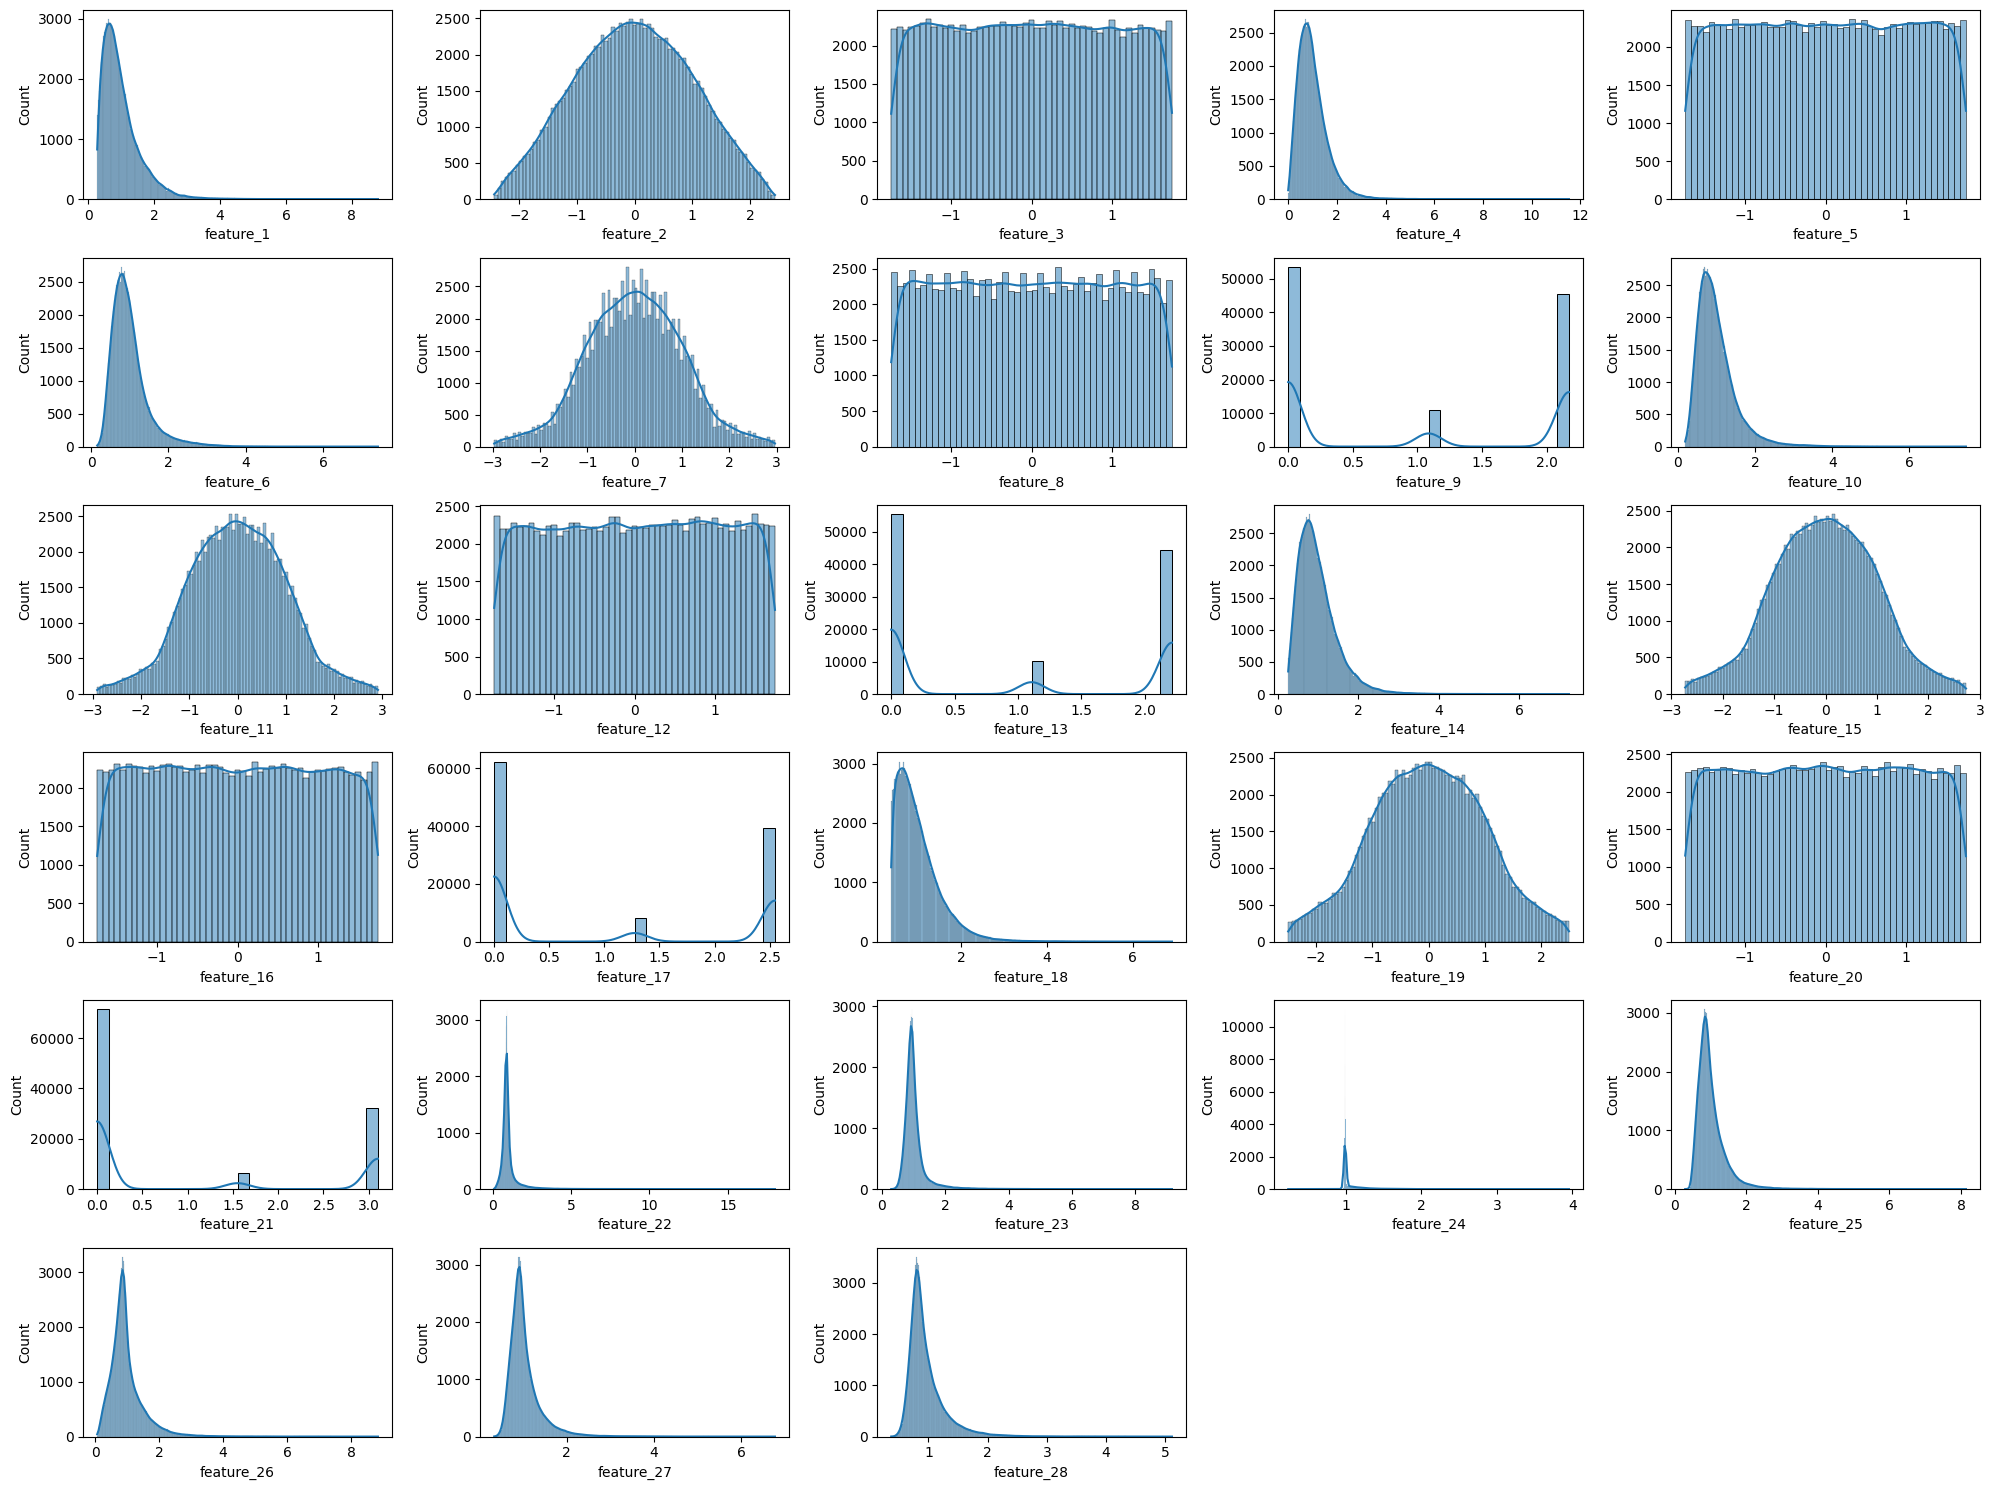

In [307]:
def beautiful_plot(df):
    plt.figure(figsize=(20, 15))
    rows, cols = (df.shape[1] + 4) // 5, 5

    for idx, column in enumerate(df.columns):
        plt.subplot(rows, cols, idx + 1)
        sns.histplot(df[column], kde=True)

    plt.tight_layout()
    plt.show()


beautiful_plot(data)

#### Covariance Matrix
- The covariance matrix ($n \times n$) contains the covariances between each pair of elements in a dataset (with $n$ variables).
\begin{bmatrix}
\text{Var}(X) & \text{Cov}(X, Y) & \text{Cov}(X, Z) \\
\text{Cov}(Y, X) & \text{Var}(Y) & \text{Cov}(Y, Z) \\
\text{Cov}(Z, X) & \text{Cov}(Z, Y) & \text{Var}(Z)
\end{bmatrix}
- The covariance between two variables $X$ and $Y$ is calculated as:
$$
\text{Cov}(X, Y) = \frac{1}{N-1} \sum_{i=1}^{N} (X_i - \bar{X})(Y_i - \bar{Y})
$$
Where $\bar{X}$ and $\bar{Y}$ are the means of $X$ and $Y$, and $N$ is the number of observations.
- A positive covariance indicates that as one variable increases, the other variable tends to increase, while a negative covariance indicates an inverse relationship.
- The covariance matrix is symmetric and provides insights into the data's distribution, variability, and correlation.



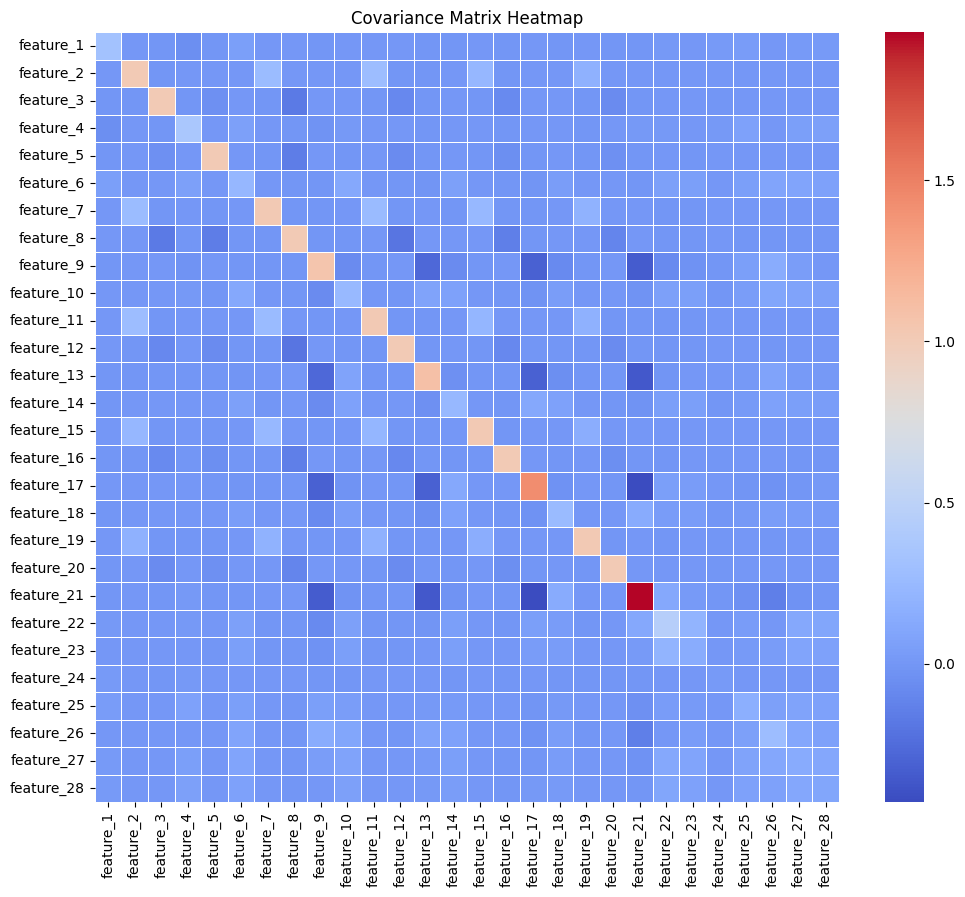

In [308]:
# Calculate the covariance matrix
cov_matrix = data.cov()

# Set up the figure size
plt.figure(figsize=(12, 10))

# Create the heatmap
sns.heatmap(cov_matrix, annot=False, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Covariance Matrix Heatmap")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

#### Outliers
Identify outliers/anomalies and clean the data accordingly.
- Check for missing values.
- After visualizing the data, it can be concluded that the features can be broadly divided into normal and skewed. Apply outlier detection method accordingly.

##### Z-Score (for normal distribution)
1. Calculate mean and standard deviation.
2. Calculate Z-Score for each point:
$$
Z_i = \frac{x_i - \mu}{\sigma}
$$
3. Data points are considered outliers if their Z-score satisfies the condition:
$$
|Z_i| > threshold
$$

##### IQR (Interquartile Range) Method
1. Compute the first quartile \(Q_1\) and the third quartile \(Q_3\) of the dataset.

2. Calculate the IQR as:
   $$
   \text{IQR} = Q_3 - Q_1
   $$

3. Define the lower and upper bounds for outliers:
   $$
   \text{Lower Bound} = Q_1 - threshold \times \text{IQR}
   $$

   $$
   \text{Upper Bound} = Q_3 + threshold \times \text{IQR}
   $$

4. Data points outside these bounds are considered outliers.


In [309]:
data.isnull().sum()  # number of missing values in each column

,0
feature_1,0
feature_2,0
feature_3,0
feature_4,0
feature_5,0
feature_6,0
feature_7,0
feature_8,0
feature_9,0
feature_10,0


In [310]:
print(f"Shape before removing outliers: {data.shape}")

outliers = {}
outlier_indices = set()

for column in data.columns:
    skewness = data[column].skew()

    if abs(skewness) < 0.5:  # Approximately normal - Use Z-score
        threshold = 3
        z_scores = zscore(data[column].dropna())
        outliers[column] = data[column][np.abs(z_scores) > threshold]
        outlier_indices.update(outliers[column].index)
        print(f"{column}: Z-score method detected {len(outliers[column])} outliers")
    else:  # Skewed or non-normal - Use IQR
        threshold = 4.5
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers[column] = data[column][
            (data[column] < Q1 - threshold * IQR) | (data[column] > Q3 + threshold * IQR)
        ]
        outlier_indices.update(outliers[column].index)
        print(f"{column}: IQR method detected {len(outliers[column])} outliers")

# Remove rows with outliers
data_cleaned = data.drop(index=outlier_indices)
target = target.drop(index=outlier_indices)
print(f"Shape after removing outliers: {data_cleaned.shape}")

Shape before removing outliers: (110000, 28)
feature_1: IQR method detected 161 outliers
feature_2: Z-score method detected 0 outliers
feature_3: Z-score method detected 0 outliers
feature_4: IQR method detected 114 outliers
feature_5: Z-score method detected 0 outliers
feature_6: IQR method detected 281 outliers
feature_7: Z-score method detected 0 outliers
feature_8: Z-score method detected 0 outliers
feature_9: Z-score method detected 0 outliers
feature_10: IQR method detected 224 outliers
feature_11: Z-score method detected 0 outliers
feature_12: Z-score method detected 0 outliers
feature_13: Z-score method detected 0 outliers
feature_14: IQR method detected 120 outliers
feature_15: Z-score method detected 0 outliers
feature_16: Z-score method detected 0 outliers
feature_17: Z-score method detected 0 outliers
feature_18: IQR method detected 122 outliers
feature_19: Z-score method detected 0 outliers
feature_20: Z-score method detected 0 outliers
feature_21: IQR method detected 0 ou

### 1.3 Data Normalization/Standardization

> "Input features were standardized over the entire train/test set with mean zero and standard deviation one, except for those features with values strictly greater than zero – these we scaled so that the mean value was one."  
> — [*Searching for Exotic Particles in High-Energy Physics with Deep Learning*](https://arxiv.org/pdf/1402.4735)



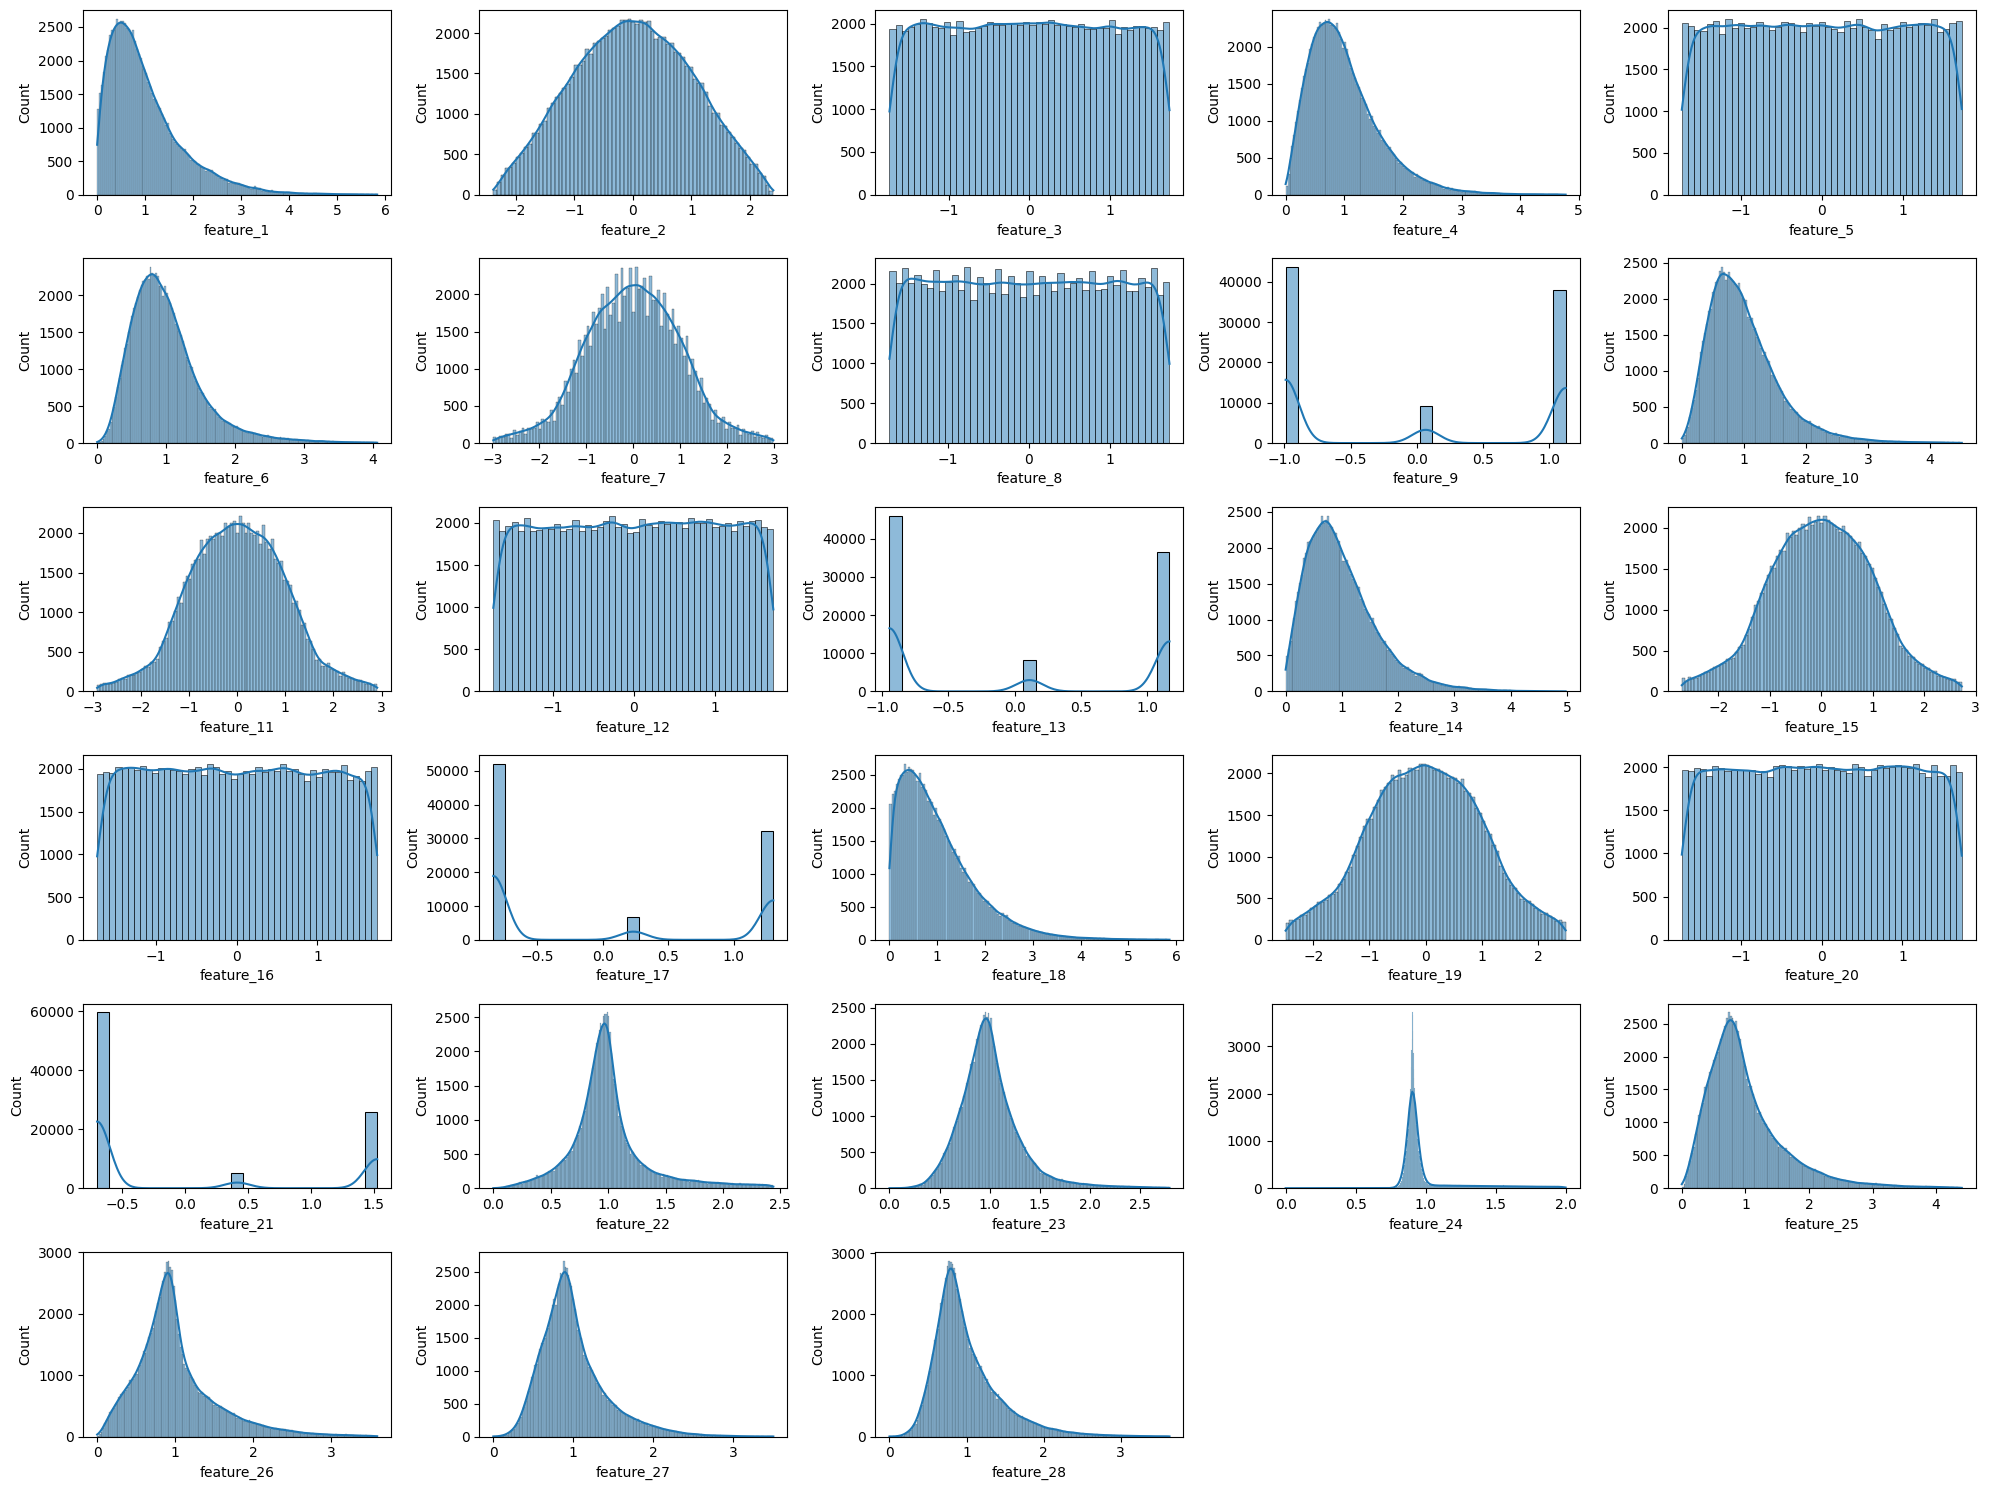

In [311]:
# Identify columns with strictly positive values
positive_only_columns = [col for col in data_cleaned.columns if (data_cleaned[col] > 0).all()]

# Separate data into positive-only and other columns
data_positive_only = data_cleaned[positive_only_columns]
data_other = data_cleaned.drop(columns=positive_only_columns)

# Standardize columns with both positive and negative values
scaler = StandardScaler()
data_other_scaled = scaler.fit_transform(data_other)
data_other_scaled = pd.DataFrame(data_other_scaled, columns=data_other.columns)

# Scale positive-only columns so the mean is 1
scaler_positive = MinMaxScaler()
data_positive_only_scaled = scaler_positive.fit_transform(data_positive_only)
data_positive_only_scaled = pd.DataFrame(
    data_positive_only_scaled, columns=data_positive_only.columns
)
data_positive_only_scaled = data_positive_only_scaled * (
    1 / data_positive_only_scaled.mean()
)

# Combine both scaled parts back into a single DataFrame
data_scaled = pd.concat([data_other_scaled, data_positive_only_scaled], axis=1)
data_scaled = data_scaled[data.columns]  # Reorder columns to match original data order

# Plot the histograms of each feature
beautiful_plot(data_scaled)

### 1.4 Feature Engineering
**Polynomial features** can capture non-linear relationships. **Interaction terms** can help capture the combined effects of multiple features. Generate interaction terms from the scaled dataset using the `PolynomialFeatures` with degree 2.

In [312]:
# Generate only interaction terms (no powers)
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_features = interaction.fit_transform(data_scaled)

# Convert to DataFrame
interaction_feature_names = interaction.get_feature_names_out(data_scaled.columns)
data_interactions = pd.DataFrame(interaction_features, columns=interaction_feature_names)

In [313]:
# Combine original and interaction features
data_engineered = pd.concat([data_scaled, data_interactions], axis=1)

print(f"Shape of engineered data: {data_engineered.shape}")

Shape of engineered data: (90806, 434)


### 1.5 Feature Selection
Remove duplicate columns and use `SelectKBest` to
identify the most important features for classification, reducing
dimensionality.

#### SelectKBest
- **Scoring**: It applies a statistical scoring function (such as ANOVA F-value, mutual information, or chi-squared) to evaluate the importance of each feature in relation to the target.
- **Selection**: It selects the \(k\) features with the highest scores, effectively filtering out the less informative features.

In [314]:
# Check for duplicate column names in the data_engineered DataFrame
duplicate_columns = data_engineered.columns[data_engineered.columns.duplicated()]

# Remove duplicates
data_engineered = data_engineered.loc[:, ~data_engineered.columns.duplicated()]

print(f"Shape of engineered data after removing duplicates: {data_engineered.shape}")

Shape of engineered data after removing duplicates: (90806, 406)


In [315]:
select_kbest = SelectKBest(score_func=f_classif, k=20)
select_kbest.fit(data_engineered, target)

# Get the selected features
selected_features_kbest = data_engineered.columns[select_kbest.get_support()]
data_reduced = data_engineered[list(selected_features_kbest)]

print(f"Shape of reduced data: {data_reduced.shape}")

Shape of reduced data: (90806, 20)


## 2. Linear SVM Implementation

### 2.1 SVM with a linear kernel (mini-batch learning)
- A **Linear Support Vector Machine (SVM)** is a supervised machine learning algorithm used for classification tasks. It seeks to find the optimal linear boundary, or hyperplane, that best separates data points of different classes.
- A SVM model is initialized using `SVC` and is evaluated by performing cross-validation (using `StratifiedKFold` strategy) on a small sample extracted from the data.


In [316]:
# Sample 1% of the data for the mini batch, keeping class distribution
data_sampled, _, target_sampled, _ = train_test_split(data_reduced, target, train_size=0.01, stratify=target, random_state=42)

In [317]:
# Initialize the linear SVM model
svm = SVC(kernel='linear', probability=True, random_state=42)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, average='weighted', multi_class='ovr', response_method="predict_proba")
}

# Perform cross-validation
cv_results = cross_validate(svm, data_sampled, target_sampled, cv=cv, scoring=scoring)

# Calculate and print mean metrics across all folds
print("SVM (Linear Kernel) Performance Metrics:")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Precision: {cv_results['test_precision'].mean():.4f}")
print(f"Recall: {cv_results['test_recall'].mean():.4f}")
print(f"F1 Score: {cv_results['test_f1'].mean():.4f}")
print(f"AUC (Area Under the ROC Curve): {cv_results['test_roc_auc'].mean():.4f}")

SVM (Linear Kernel) Performance Metrics:
Accuracy: 0.6277
Precision: 0.6499
Recall: 0.6277
F1 Score: 0.6012
AUC (Area Under the ROC Curve): 0.6530


### 2.2 Stochastic Gradient Descent (SGD)
- **SGD** is an optimization method that updates model parameters incrementally with each training example rather than in batches. Each iteration updates the model's weights based on a single example, which is computationally efficient and allows handling of large-scale datasets.
- `SGDClassifier(loss='hinge')` configures the classifier to minimize the **hinge loss**, which is the loss function used by linear SVMs.

In [318]:
# Initialize the SGDClassifier with a linear SVM loss function
sgd_clf = SGDClassifier(loss='hinge', random_state=42, max_iter=1000)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Perform cross-validation
cv_results = cross_validate(sgd_clf, data_reduced, target, cv=cv, scoring=scoring)

# Calculate and print mean metrics across all folds
print("SGDClassifier Performance Metrics:")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Precision: {cv_results['test_precision'].mean():.4f}")
print(f"Recall: {cv_results['test_recall'].mean():.4f}")
print(f"F1 Score: {cv_results['test_f1'].mean():.4f}")

SGDClassifier Performance Metrics:
Accuracy: 0.6228
Precision: 0.6525
Recall: 0.6228
F1 Score: 0.5909


#### Key Classification Metrics
1. Accuracy \
The proportion of correct predictions (both true positives and true negatives) out of the total predictions.
$$
\text{Accuracy} = \frac{\text{TP + TN}}{\text{TP + TN + FP + FN}}
$$
2. Precision \
The ratio of correctly predicted positive observations to the total predicted positives.
$$
\text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$
3. Recall (Sensitivity or True Positive Rate) \
The ratio of correctly predicted positive observations to all actual positives.
$$
\text{Recall} = \frac{\text{TP}}{\text{TP + FN}}
$$
4. F1-Score \
The harmonic mean of precision and recall, balancing the two metrics.
$$
\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision + Recall}}
$$
5. AUC (Area Under the ROC Curve) \
Represents the area under the Receiver Operating Characteristic (ROC) curve, plotting the true positive rate (recall) against the false positive rate.\
Range: 0 to 1, where 1 is a perfect model.

<!-- | Metric        | Best for...                     |
|---------------|---------------------------------|
| **Accuracy**  | Balanced datasets               |
| **Precision** | Reducing false positives        |
| **Recall**    | Reducing false negatives        |
| **F1-Score**  | Balancing precision and recall  |
| **AUC**       | Overall discrimination ability  | -->

## 3. Comparison and Time Complexity Analysis of SVM with various Kernels

In [319]:
# Sample 80% of data for training and 20% for testing, keeping class distribution
data_train, data_test, target_train, target_test = train_test_split(
    data_sampled, target_sampled, train_size=0.8, stratify=target_sampled, random_state=42
)

In [320]:
# Function to evaluate the model and capture computation time
def evaluate_model(model, data_train, target_train, data_test, target_test):

    # Training
    start_time = time()
    model.fit(data_train, target_train)
    end_time = time()
    training_time = end_time - start_time

    # Prediction
    start_time = time()
    predictions = model.predict(data_test)
    end_time = time()
    prediction_time = end_time - start_time

    # Performance Metrics
    accuracy = accuracy_score(target_test, predictions)
    precision = precision_score(target_test, predictions)
    recall = recall_score(target_test, predictions)
    f1 = f1_score(target_test, predictions)
    auc = roc_auc_score(target_test, model.decision_function(data_test))

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'training_time': training_time,
        'prediction_time': prediction_time
    }

In [321]:
# Function to print performance metrics
def print_metrics(metrics):
  print("Metrics:")
  print(f"  Accuracy: {metrics['accuracy']:.4f}")
  print(f"  Precision: {metrics['precision']:.4f}")
  print(f"  Recall: {metrics['recall']:.4f}")
  print(f"  F1 Score: {metrics['f1_score']:.4f}")
  print(f"  AUC: {metrics['auc']:.4f}")
  print(f"  Training Time: {metrics['training_time']:.4f} seconds")
  print(f"  Prediction Time: {metrics['prediction_time']:.4f} seconds")

#### Grid Search
- `GridSearchCV` is a hyperparameter tuning technique that automates the process of finding the optimal combination of hyperparameters for a given model.
- `param_grid`: grid of possible hyperparameter values
- Performance metric used for scoring: **accuracy**

### 3.1 Polynomial Kernel

In [322]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Polynomial Kernel with varying degrees and parameter tuning
poly_results = {}
param_grid = {
    'C': [0.1, 1, 10, 100],
    'degree': [2, 3, 4]
}

poly_svm = SVC(kernel='poly', random_state=42)
grid_search = GridSearchCV(poly_svm, param_grid, scoring='accuracy', cv=5)
grid_search.fit(data_train, target_train)

# Capture results and performance metrics for the best model
best_model = grid_search.best_estimator_
poly_results['best_params'] = grid_search.best_params_
poly_results['metrics'] = evaluate_model(best_model, data_train, target_train, data_test, target_test)
metrics = poly_results['metrics']

# Print the results
print("Polynomial Kernel")
print(f"Best Parameters: C={grid_search.best_params_['C']}, Degree={grid_search.best_params_['degree']}")
print_metrics(metrics)

Polynomial Kernel
Best Parameters: C=100, Degree=2
Metrics:
  Accuracy: 0.6484
  Precision: 0.6429
  Recall: 0.7500
  F1 Score: 0.6923
  AUC: 0.6846
  Training Time: 0.4228 seconds
  Prediction Time: 0.0039 seconds


### 3.2 RBF Kernel

In [323]:
# RBF Kernel with varying gamma and parameter tuning
rbf_results = {}

# Define the parameter grid to include both C and gamma
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10]
}

# Initialize the RBF SVM and perform grid search
rbf_svm = SVC(kernel='rbf', random_state=42)
grid_search = GridSearchCV(rbf_svm, param_grid, scoring='accuracy', cv=5)
grid_search.fit(data_train, target_train)

# Capture results and performance metrics for the best model
best_model = grid_search.best_estimator_
rbf_results['best_params'] = grid_search.best_params_
rbf_results['metrics'] = evaluate_model(best_model, data_train, target_train, data_test, target_test)
metrics = rbf_results['metrics']

# Print the results
print("RBF Kernel")
print(f"Best Parameters: C={grid_search.best_params_['C']}, Gamma={grid_search.best_params_['gamma']}")
print_metrics(metrics)

RBF Kernel
Best Parameters: C=100, Gamma=0.01
Metrics:
  Accuracy: 0.6648
  Precision: 0.6549
  Recall: 0.7708
  F1 Score: 0.7081
  AUC: 0.6797
  Training Time: 0.0347 seconds
  Prediction Time: 0.0071 seconds


### 3.3 Custom Hybrid Kernel
$$ HybridKernel(X,Y)=α⋅RBF(X,Y)+(1−α)⋅Linear(X,Y) $$

In [324]:
# Define a custom kernel class with set_params and get_params
class HybridKernel:
    def __init__(self, gamma=0.1, alpha=0.5):
        self.gamma = gamma
        self.alpha = alpha

    def __call__(self, X, Y):
        rbf_part = rbf_kernel(X, Y, gamma=self.gamma)
        linear_part = linear_kernel(X, Y)
        return self.alpha * rbf_part + (1 - self.alpha) * linear_part

    # Allow GridSearchCV to set parameters
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

    # Allow GridSearchCV to get parameters
    def get_params(self, deep=True):
        return {"gamma": self.gamma, "alpha": self.alpha}

# Define the parameter grid including C, gamma, and alpha
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel__gamma': [0.01, 0.1, 1],
    'kernel__alpha': [0.3, 0.5, 0.7]
}

# Initialize the custom kernel and SVC with custom kernel
custom_kernel = HybridKernel()
custom_svm = SVC(kernel=custom_kernel, random_state=42)

# Use GridSearchCV with the custom kernel and parameter grid
grid_search = GridSearchCV(custom_svm, param_grid, scoring='accuracy', cv=5)
grid_search.fit(data_train, target_train)

# Capture results and performance metrics for the best model
best_model = grid_search.best_estimator_
custom_results = evaluate_model(best_model, data_train, target_train, data_test, target_test)
metrics = custom_results

# Print the results
print("Custom Hybrid Kernel")
print(f"Best Parameters: C={grid_search.best_params_['C']}, Gamma={grid_search.best_params_['kernel__gamma']}, Alpha={grid_search.best_params_['kernel__alpha']}")
print_metrics(metrics)


Custom Hybrid Kernel
Best Parameters: C=10, Gamma=1, Alpha=0.5
Metrics:
  Accuracy: 0.5824
  Precision: 0.6087
  Recall: 0.5833
  F1 Score: 0.5957
  AUC: 0.6118
  Training Time: 0.1886 seconds
  Prediction Time: 0.0169 seconds


### 3.4 Comparison of the Kernels' Performance

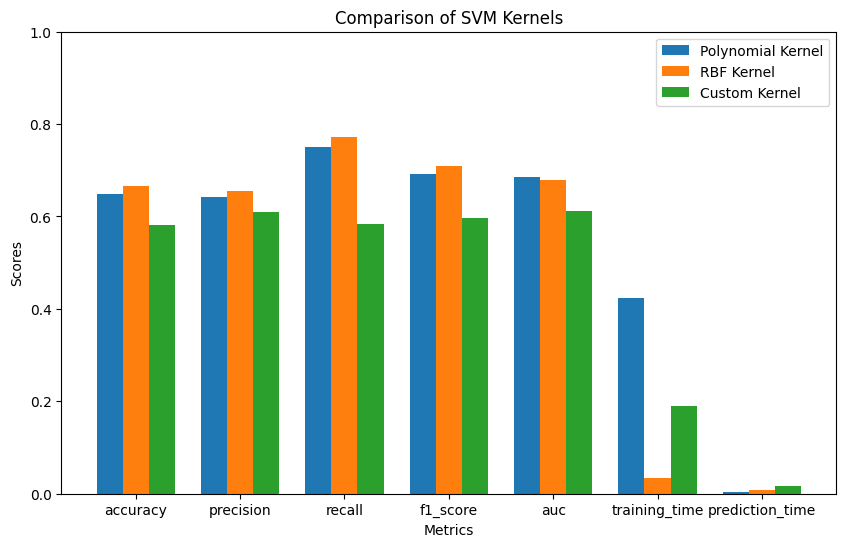

In [325]:
# Extract metric names and corresponding values
metrics = list(poly_results['metrics'].keys())
poly_values = list(poly_results['metrics'].values())
rbf_values = list(rbf_results['metrics'].values())
custom_values = list(custom_results.values())

# Set up bar width and positions for each kernel
bar_width = 0.25
x = np.arange(len(metrics))

# Plotting the bars for each kernel
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, poly_values, width=bar_width, label='Polynomial Kernel')
plt.bar(x, rbf_values, width=bar_width, label='RBF Kernel')
plt.bar(x + bar_width, custom_values, width=bar_width, label='Custom Kernel')

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of SVM Kernels')
plt.xticks(x, metrics)
plt.ylim(0, 1)  # Assuming scores are between 0 and 1
plt.legend()

# Display the plot
plt.show()

## 4. Hyperparameter Tuning
-  Chosen SVM Kernel: **RBF**
- Advanced methods such as Bayesian Optimization and Random Search are used for tuning hyperparameters (C and gamma), and analysing sensitivity of the SVM performance to different hyperparameters.

### 4.1 Bayesian Optimization
`BayesSearchCV` is an implementation of Bayesian Optimization, a probabilistic model-based approach for optimizing hyperparameters.
- Uses a **surrogate model** (often a Gaussian Process) to approximate the objective function.
- Utilizes an **acquisition function** to balance exploration and exploitation of the hyperparameter space.
- Iteratively updates the model based on previously evaluated hyperparameters.

In [326]:
# Define the search space for Bayesian Optimization
search_space = {
    'C': (1e-3, 1e3, 'uniform'),  # C values from 0.001 to 1000
    'gamma': (1e-4, 1e1, 'log-uniform'),  # gamma values from 0.0001 to 10
}

# Bayesian Optimization for RBF Kernel
bayes_search_rbf = BayesSearchCV(SVC(kernel='rbf', random_state=42), search_space, n_iter=20, scoring='accuracy', cv=5)
bayes_search_rbf.fit(data_train, target_train)

# Capture optimal values and performance metrics
best_bayes_rbf_model = bayes_search_rbf.best_estimator_
bayes_rbf_results = evaluate_model(best_bayes_rbf_model, data_train, target_train, data_test, target_test)
optimal_c = bayes_search_rbf.best_params_['C']
optimal_gamma = bayes_search_rbf.best_params_['gamma']
metrics = bayes_rbf_results

print(f"Optimal Parameters for RBF Kernel:\n"
      f"  C: {optimal_c}\n"
      f"  Gamma: {optimal_gamma}\n")
print_metrics(metrics)

Optimal Parameters for RBF Kernel:
  C: 1000.0
  Gamma: 0.0043693413490969125

Metrics:
  Accuracy: 0.6319
  Precision: 0.6306
  Recall: 0.7292
  F1 Score: 0.6763
  AUC: 0.6731
  Training Time: 0.0768 seconds
  Prediction Time: 0.0070 seconds


### 4.2 Hyperparameter Sensitivity Analysis

`RandomizedSearchCV` is a hyperparameter tuning method that samples from a specified distribution for each hyperparameter, allowing for a random selection of combinations to evaluate.
- Evaluates a fixed number of parameter settings (defined by `n_iter`) rather than all possible combinations.


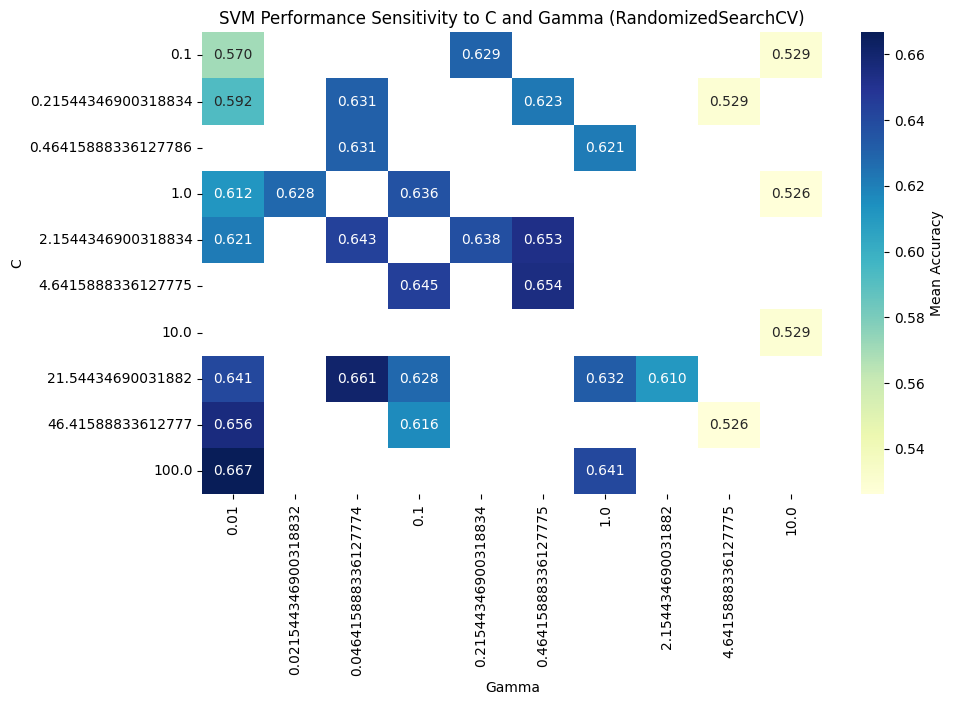

Best Parameters: {'gamma': 0.01, 'C': 100.0}
              precision    recall  f1-score   support

         0.0       0.68      0.55      0.61        86
         1.0       0.65      0.77      0.71        96

    accuracy                           0.66       182
   macro avg       0.67      0.66      0.66       182
weighted avg       0.67      0.66      0.66       182



In [327]:
# Define the parameter distribution for C and gamma
param_dist = {
    'C': np.logspace(-1, 2, num=10),  # C values from 0.1 to 100
    'gamma': np.logspace(-2, 1, num=10) # gamma values from 0.01 to 10
}

# Initialize the SVC model
svm = SVC(kernel='rbf', random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=30, scoring='accuracy', cv=5, n_jobs=-1, random_state=42)
random_search.fit(data_train, target_train)

# Extract results into a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Create a pivot table for heatmap visualization
heatmap_data = results.pivot(index='param_C', columns='param_gamma', values='mean_test_score')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'Mean Accuracy'})
plt.title('SVM Performance Sensitivity to C and Gamma (RandomizedSearchCV)')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.show()

# Print the best parameters and classification report
print(f"Best Parameters: {random_search.best_params_}")
best_model = random_search.best_estimator_
y_pred = best_model.predict(data_test)
print(classification_report(target_test, y_pred))

## 5. Analysis and Report